In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from data import *
from utils import *
from NMF import *
import time
import pandas as pd
import seaborn
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

2023-03-14 15:50:02.996039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martilud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from NMF import *


NMF_sep_unit_tests()

Exemplar-based fitting OK


UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [2]:
np.random.seed(0)
mnist = MNIST()
Ms = [1,0]
M = len(Ms)
N_adv = 2500
N_sup = 1000
N_V = 2500
N_sup_test = 1000
d = 128

mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
U_r = []
for i in range(M):
    U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((N_adv,784)).T))
V = np.copy(mnist.x_v_train.reshape((N_V,784)).T)

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)

V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
U_test_fit = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
    U_test_fit.append(U_test[:,i,:])


In [78]:
np.random.seed(0)
sep_adv = NMF_separation(ds = [d,d], prob = "semi_adv", normalize = True, epochs = 100, tau_A = [0.1,0.0], mu_H = 1e-6, mu_W = 1e-6, batch_size = 500, batch_size_z = 250, batch_size_sup = 500)
sep_adv.fit(U_r = U_r, V = V_sup)
W_semi_adv = np.copy(sep_adv.NMF_concat.W)

In [79]:
np.random.seed(0)
sep = NMF_separation(ds = [d,d], prob = "semi", normalize = True, epochs = 100, tau_A = 0.025, mu_H = 1e-6, mu_W = 1e-6, batch_size = 500, batch_size_z = 100, batch_size_sup = 500)
sep.fit(U_r = U_r, V = V_sup)
W_semi = np.copy(sep.NMF_concat.W)

In [80]:
np.random.seed(0)
sep_adv_single = NMF_separation(ds = [d], prob = "adv", normalize = True, epochs = 100, tau_A = 0.1, mu_H = 1e-6, mu_W = 1e-6, batch_size = 500, batch_size_z = 250, batch_size_sup = 500, wiener = False)
sep_adv_single.fit(U_r = [U_r[0]], V = V_sup)
W_semi_adv_single = np.copy(sep_adv_single.NMF_concat.W)

In [81]:
np.random.seed(0)
sep_std_single = NMF_separation(ds = [d], prob = "std", normalize = True, epochs = 100, tau_A = 0.2, mu_H = 1e-6, mu_W = 1e-6, batch_size = 500, batch_size_z = 250, batch_size_sup = 500, wiener = False)
sep_std_single.fit(U_r = [U_r[0]])
W_semi_std_single = np.copy(sep_std_single.NMF_concat.W)

In [36]:
print(sep_adv_single.NMF_concat.W.shape)

(784, 64)


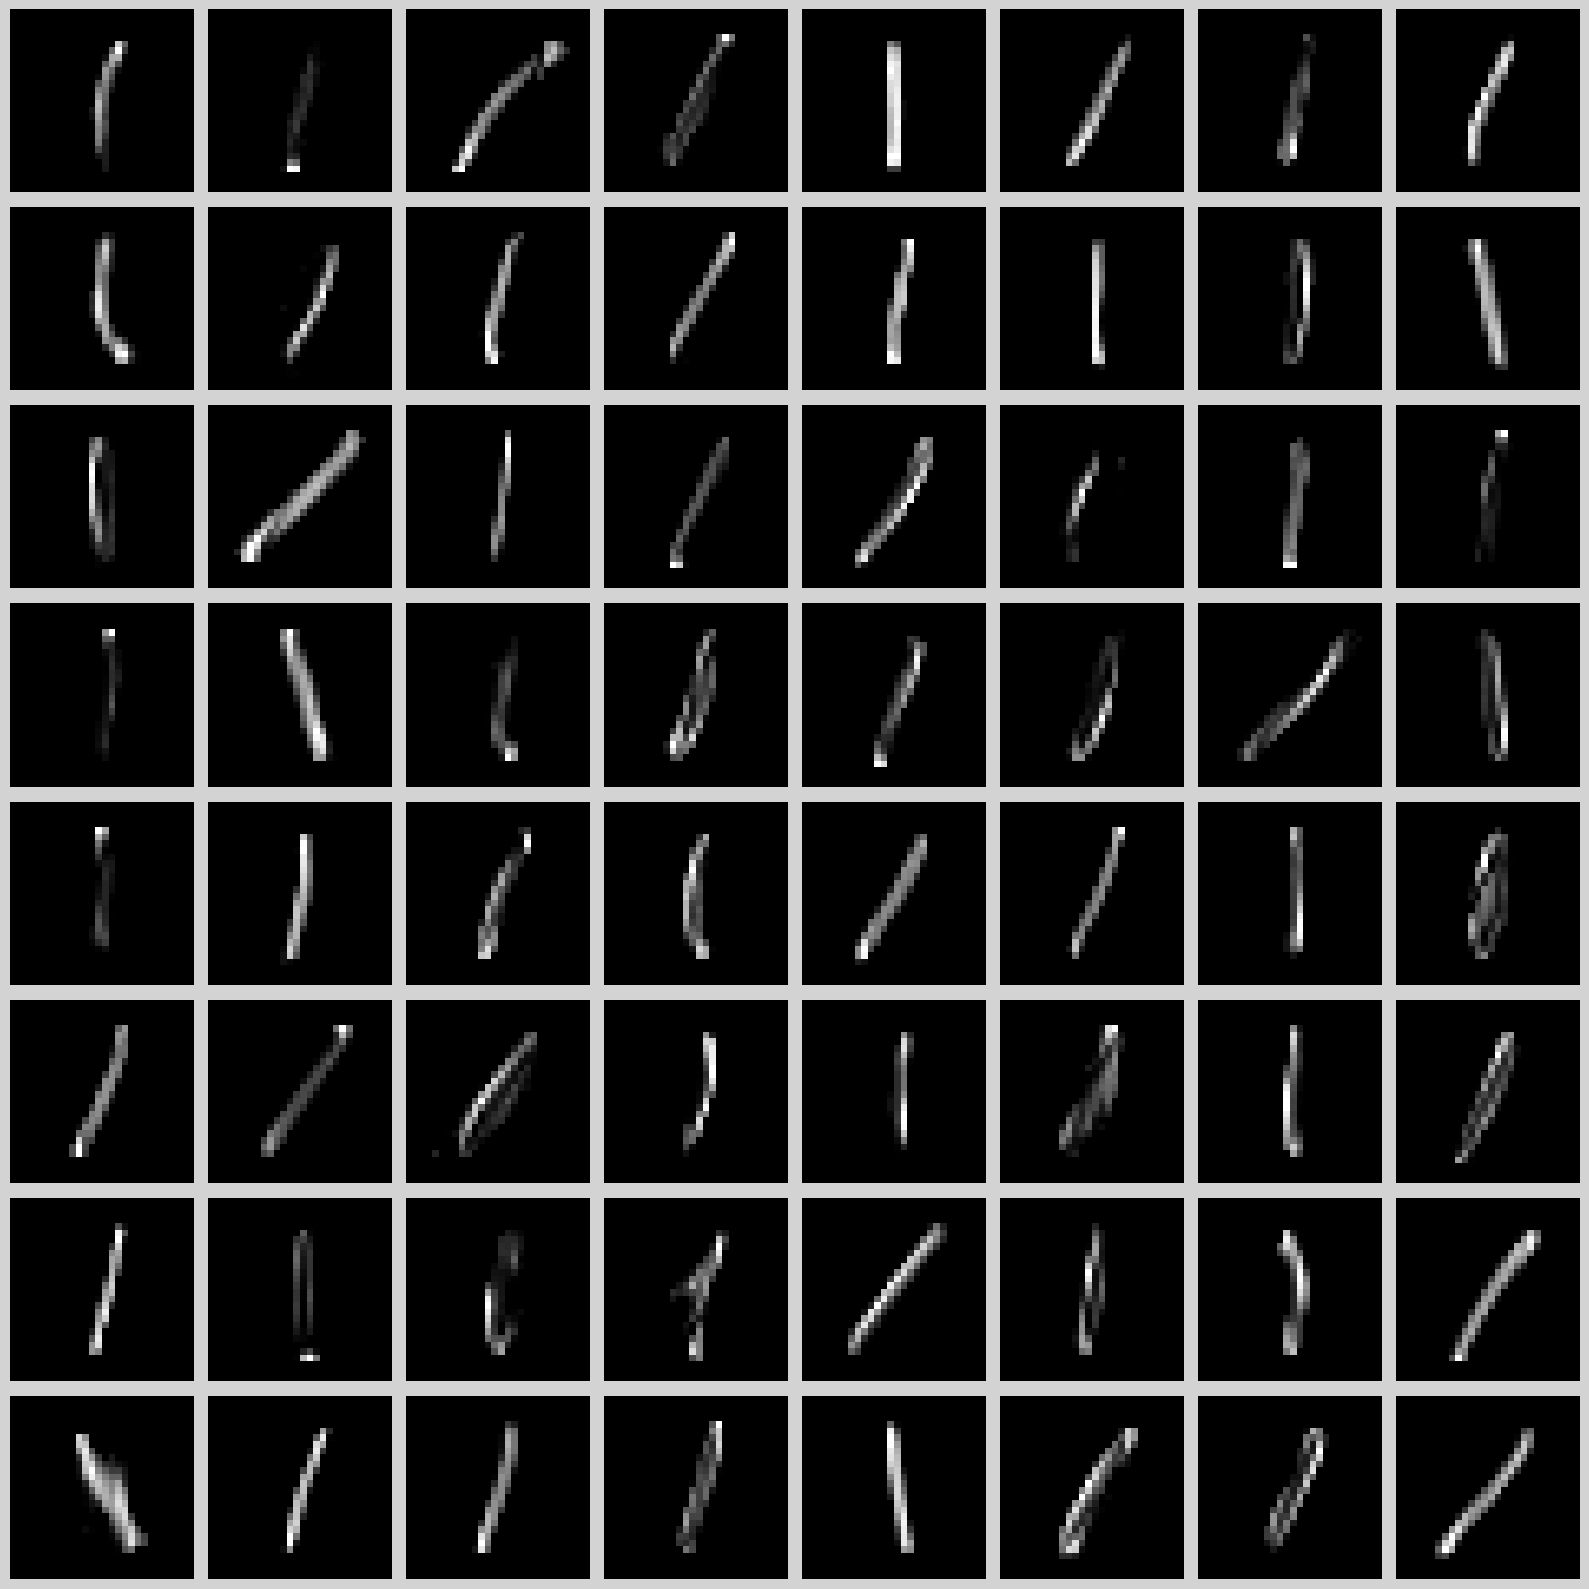

In [37]:
plotimgs(W_semi_adv_single.T.reshape((64,28,28)), nplot = 8)

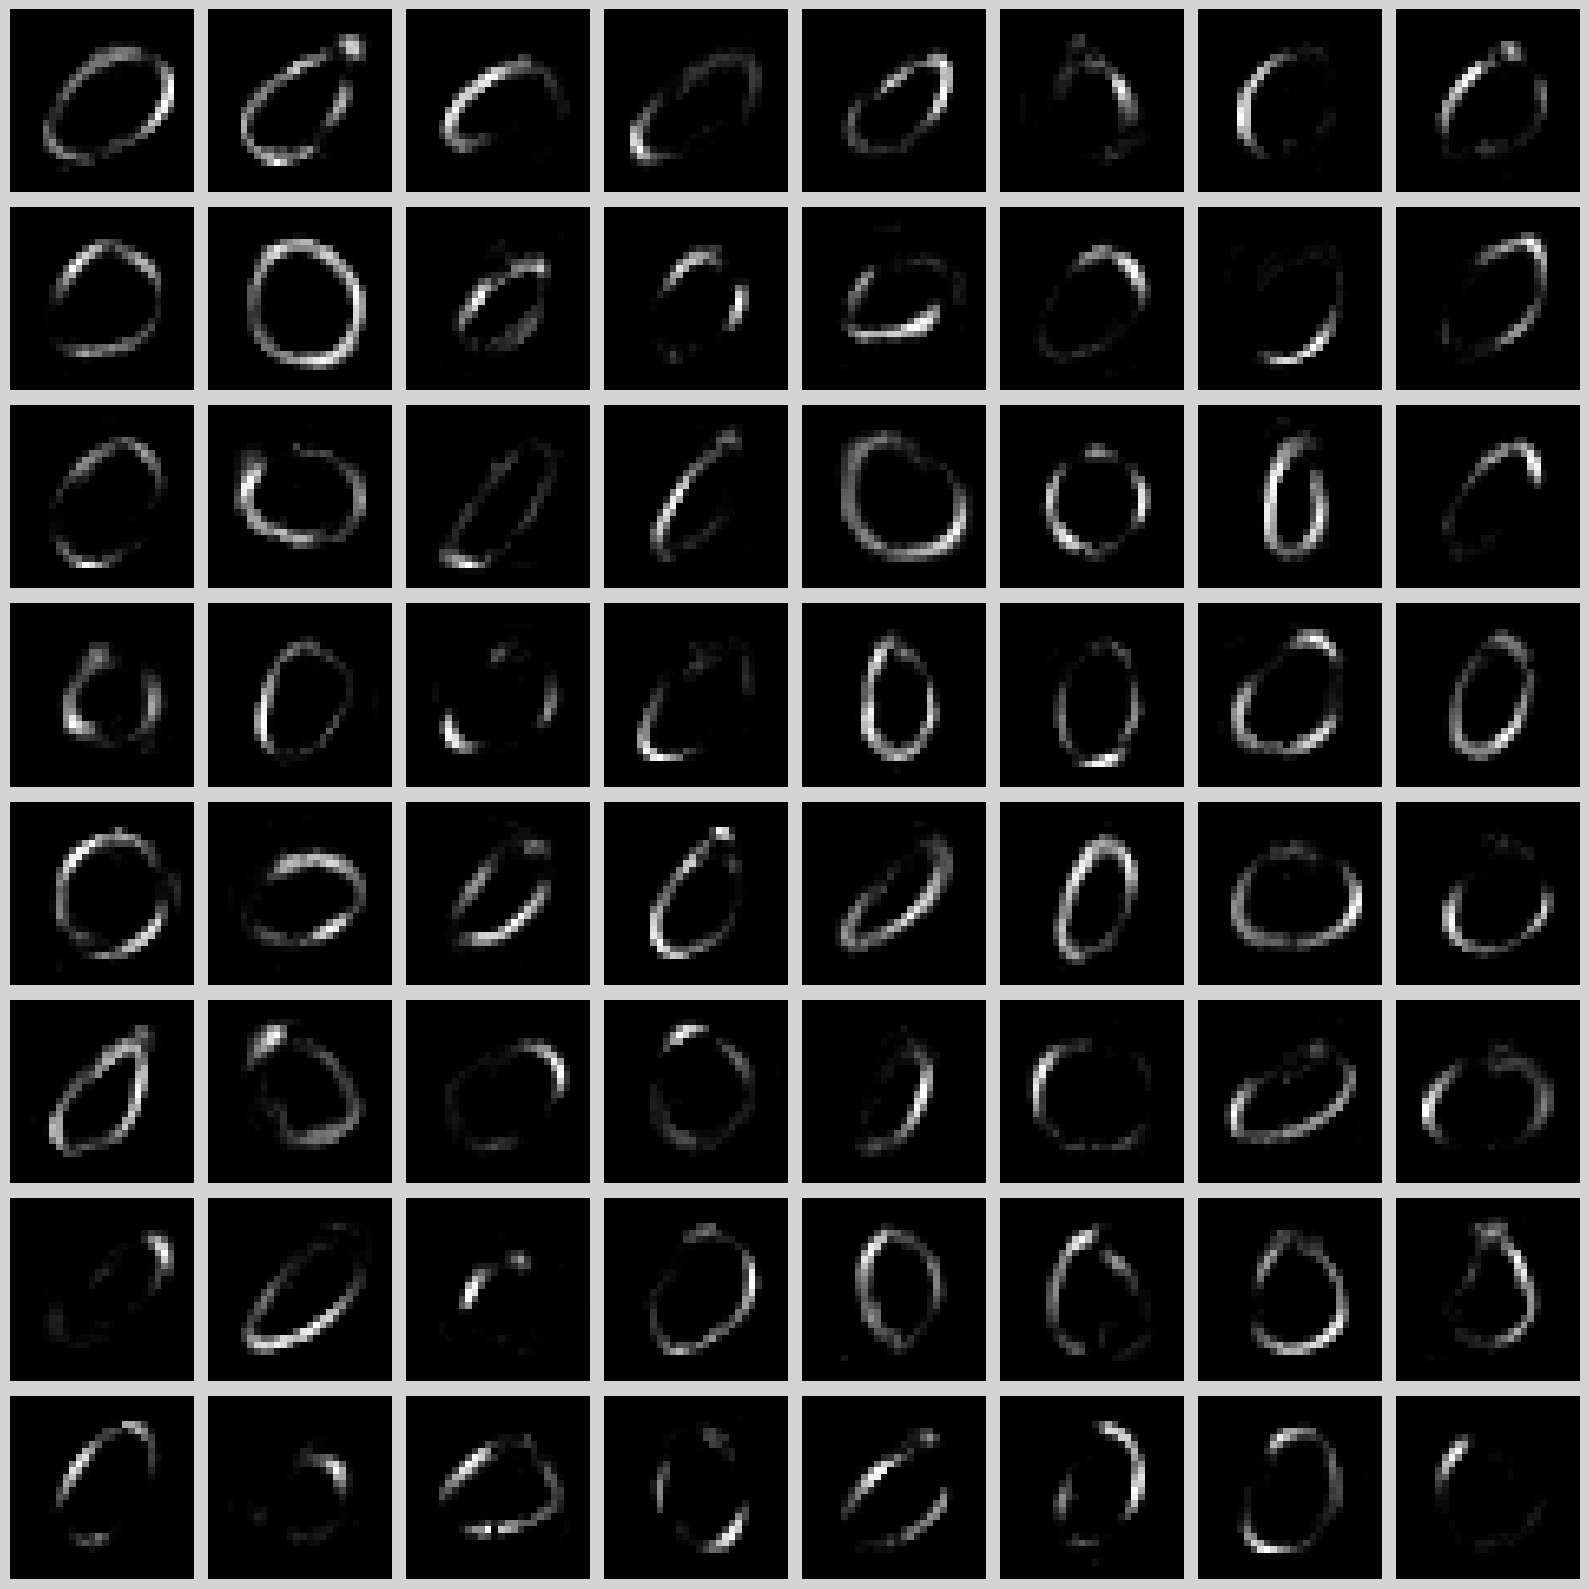

In [5]:
plotimgs(W_semi_adv.T.reshape((128,28,28))[64:], nplot = 8)

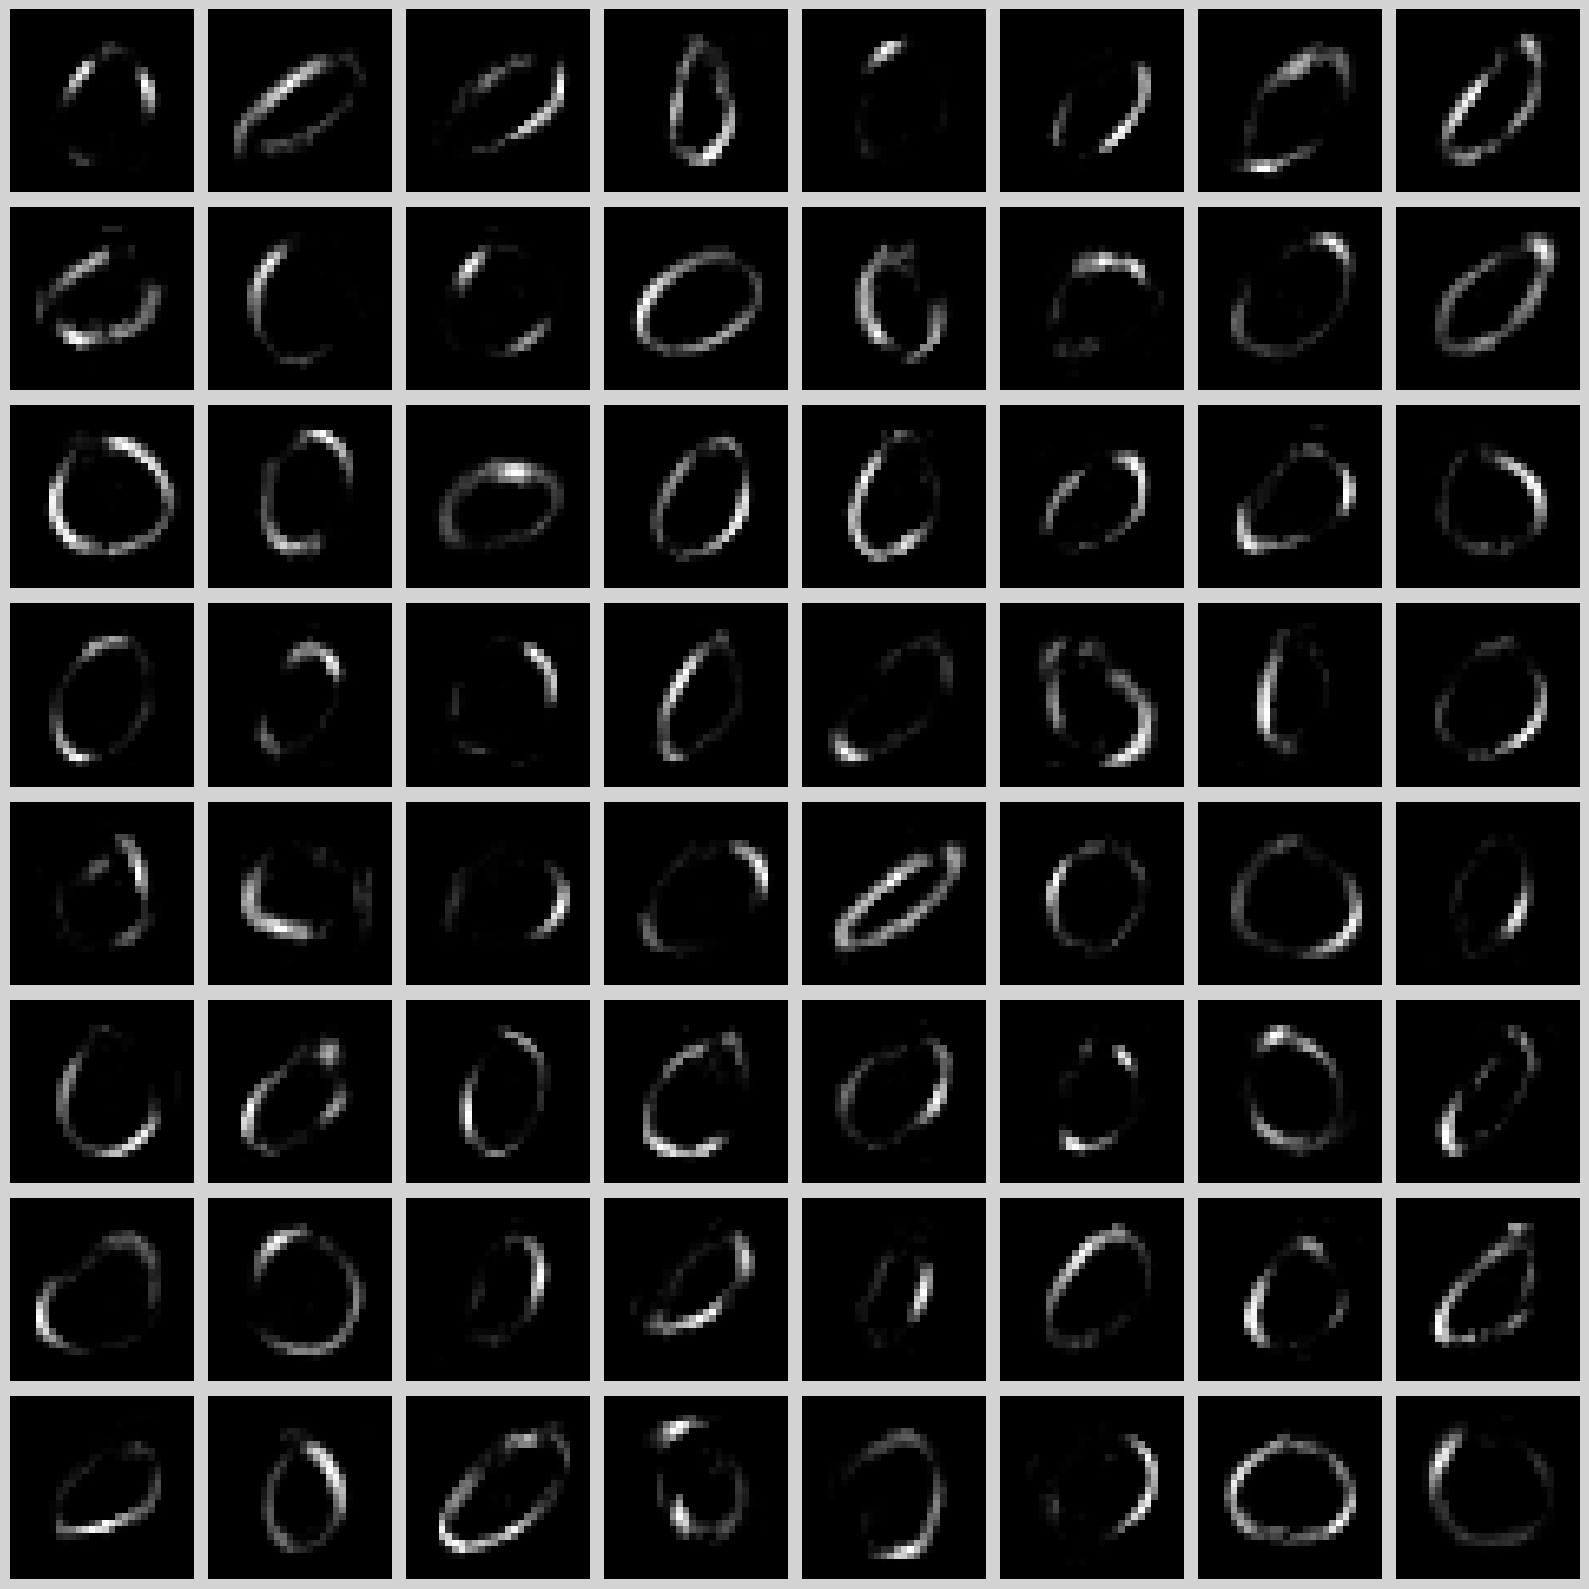

In [6]:
plotimgs(W_semi.T.reshape((128,28,28))[64:], nplot = 8)

In [82]:
U_adv = sep_adv.separate(V_sup, current = True)
U_std = sep.separate(V_sup, current = True)
U_adv_single = sep_adv_single.separate(V_sup)
U_std_single = sep_std_single.separate(V_sup)

out_adv = sep_adv.eval(U_test = U_s, V_test = V_sup, current = True, weights = [1.0,0.0], metric = 'psnr')
print(np.median(out_adv))
out_std = sep.eval(U_test = U_s, V_test = V_sup, current = True,weights = [1.0,0.0], metric = 'psnr')
print(np.median(out_std))
out_adv_single = sep_adv_single.eval(U_test = U_s, V_test = V_sup, weights = [1.0,0.0], metric = 'psnr')
print(np.median(out_adv_single))
out_std_single = sep_std_single.eval(U_test = U_s, V_test = V_sup, weights = [1.0,0.0], metric = 'psnr')
print(np.median(out_std_single))

24.966681941971714
19.13862879386958
14.851292976474316
11.460177644839813


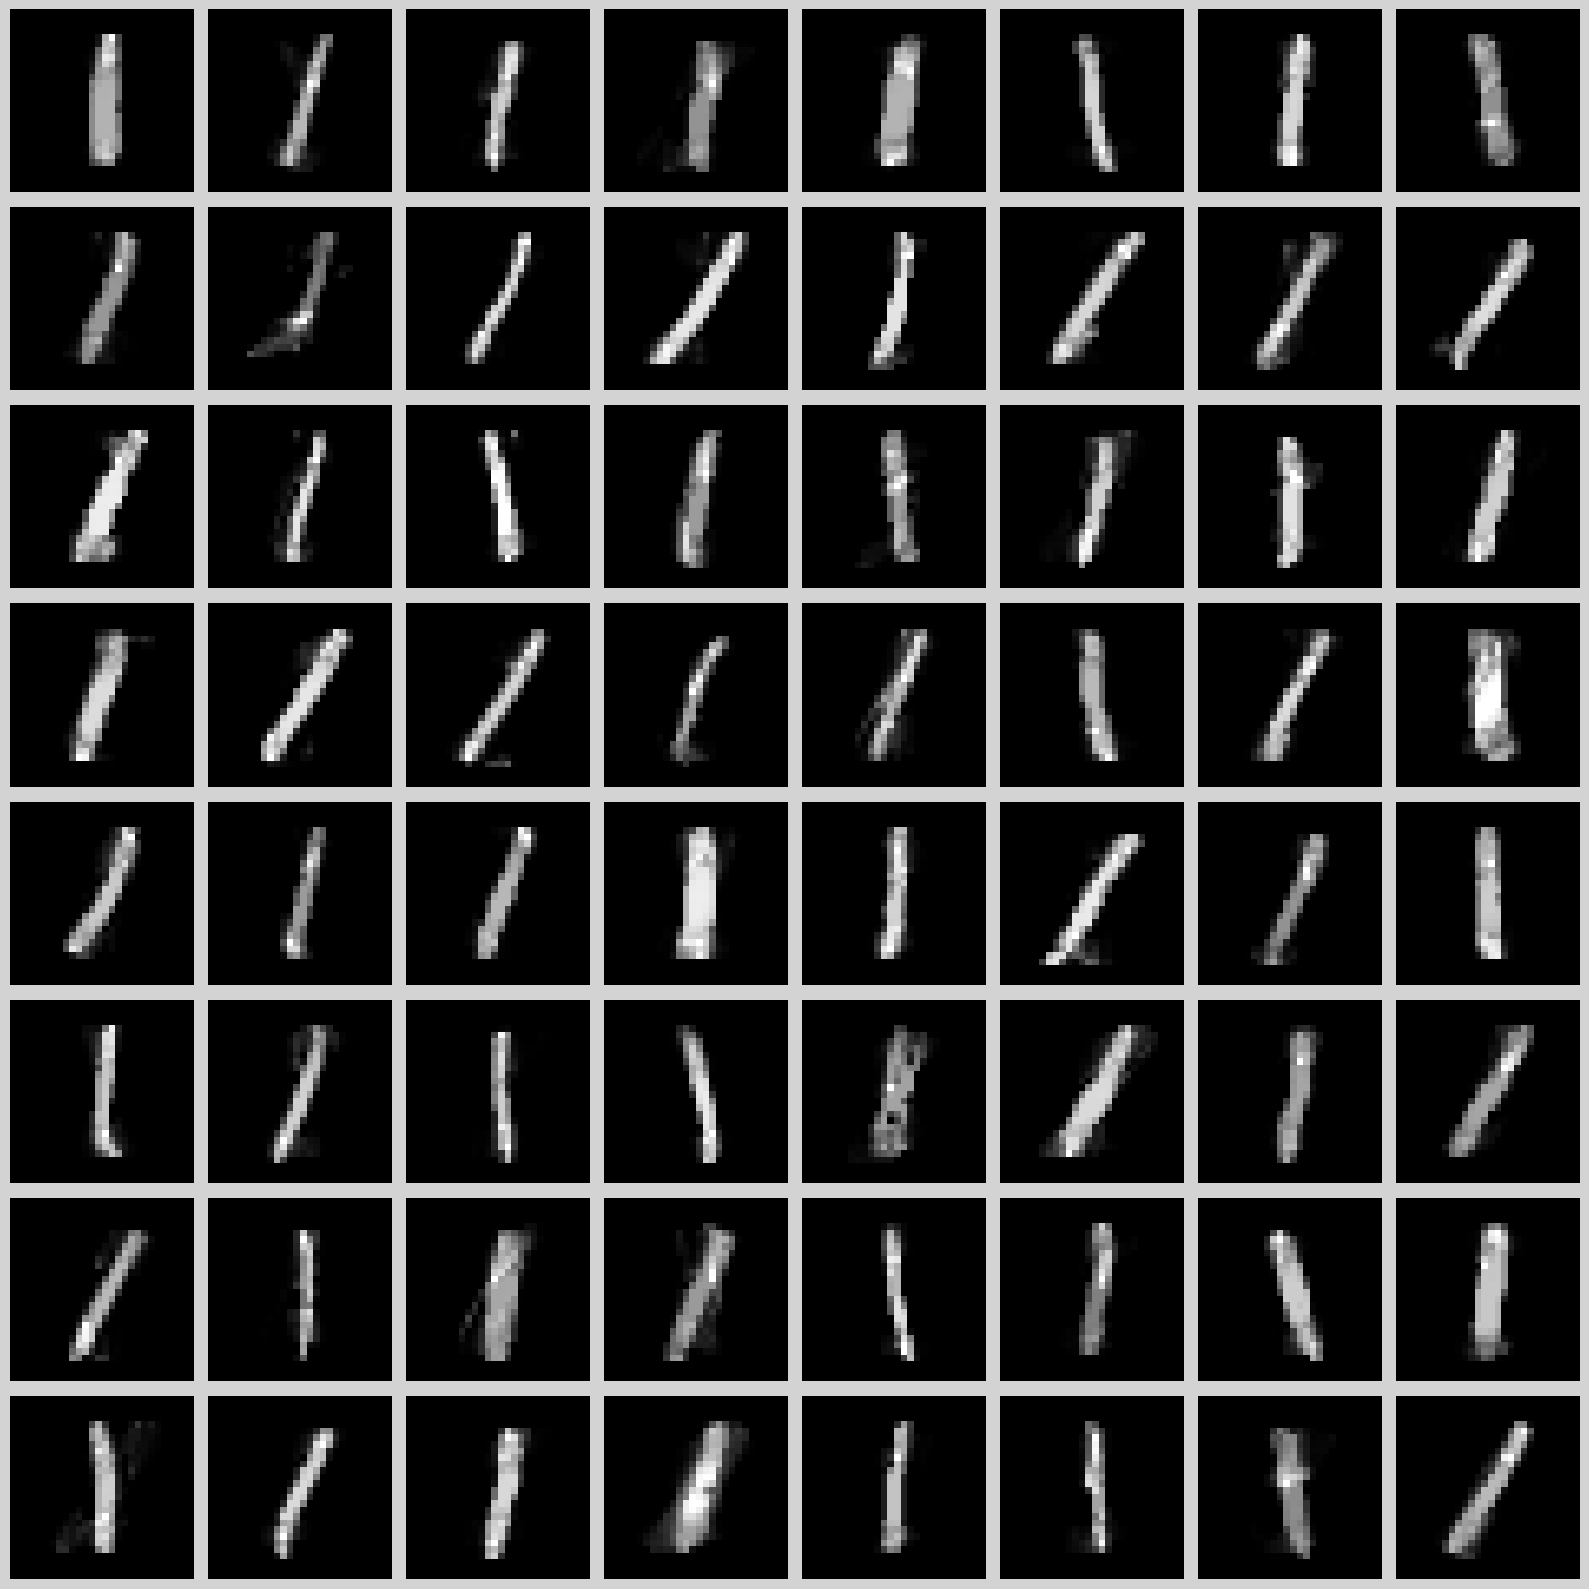

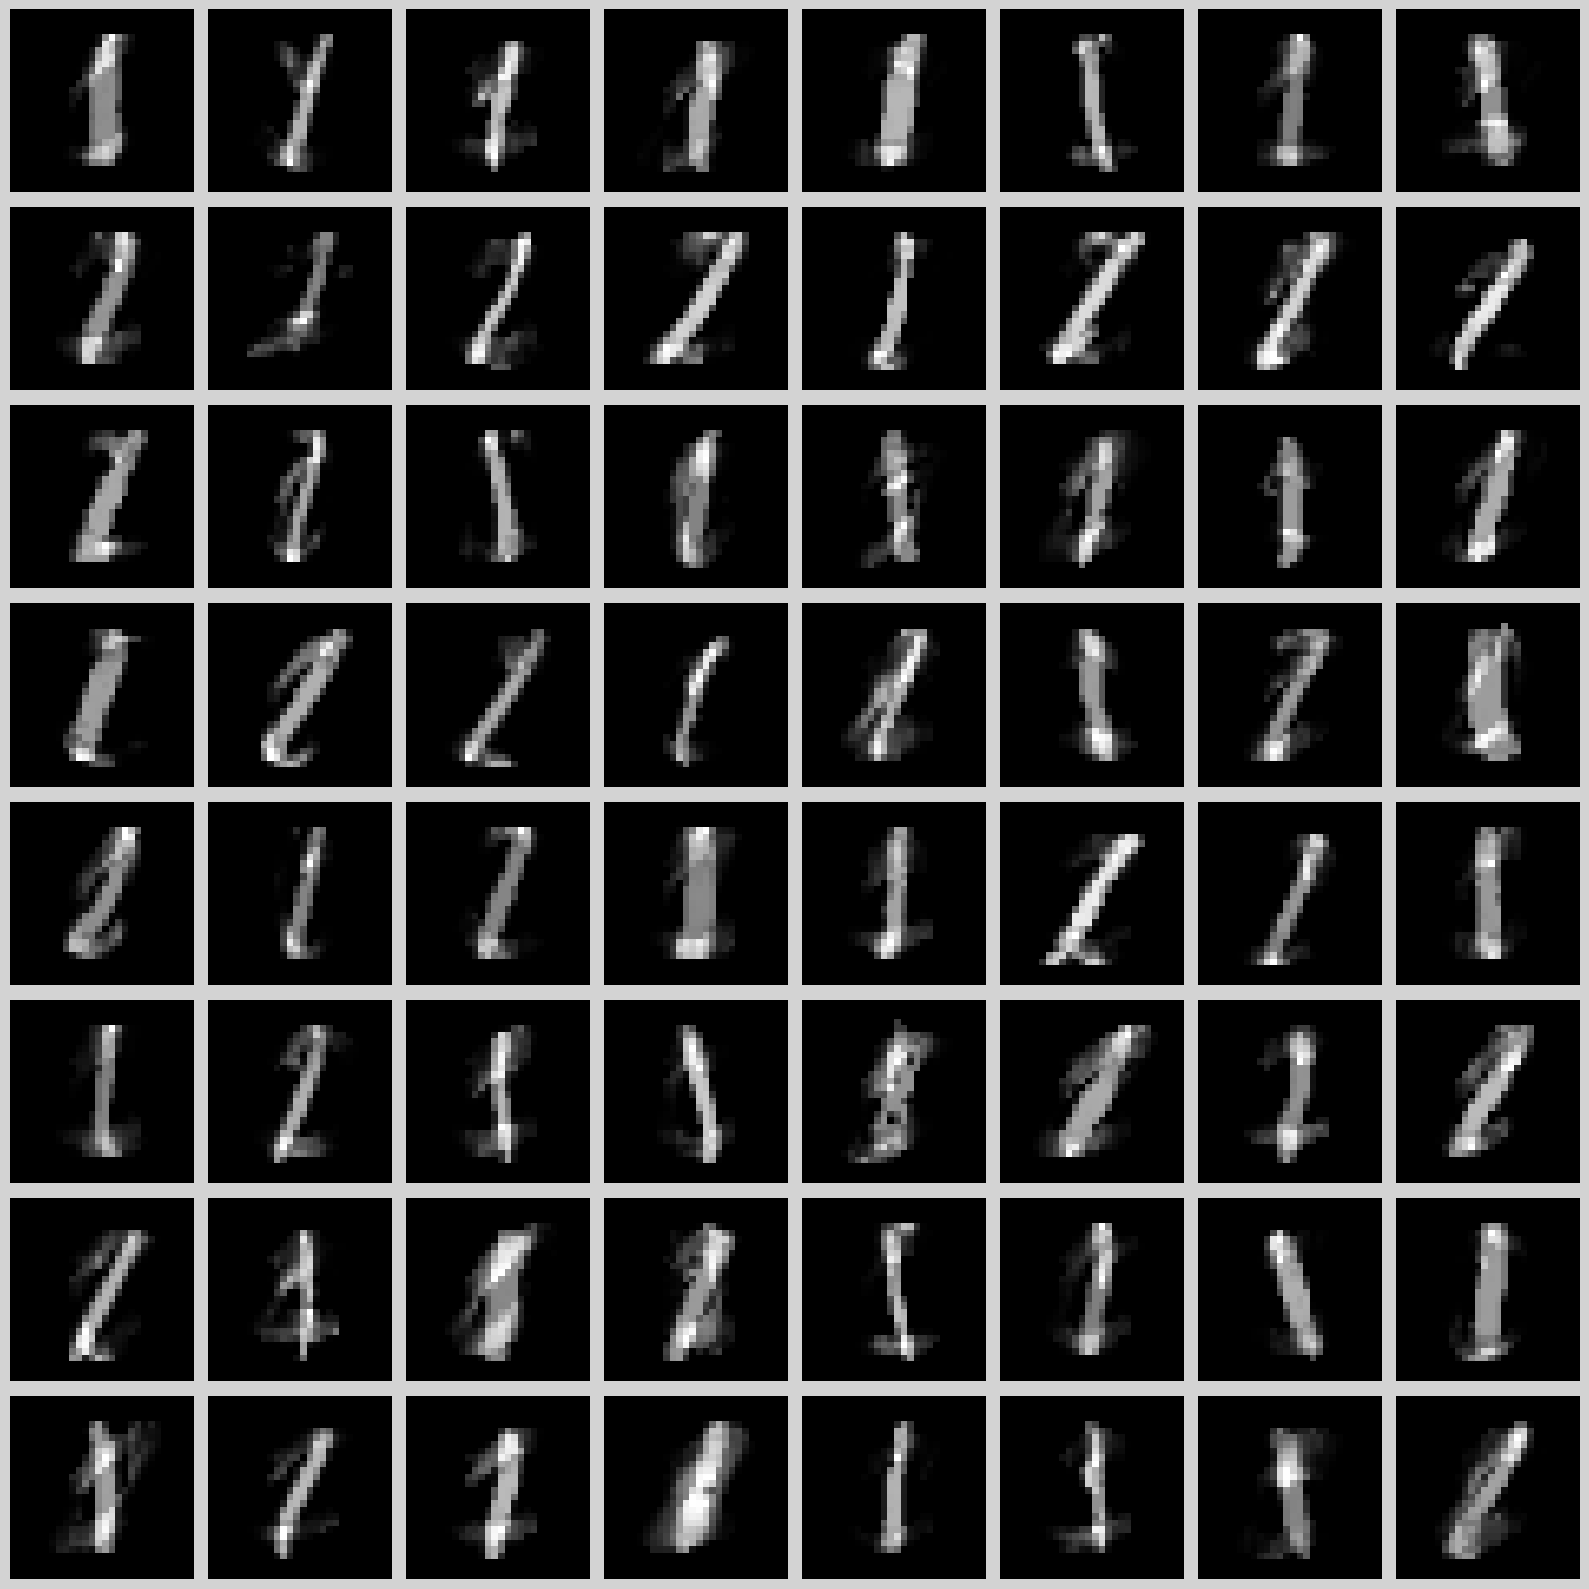

In [83]:
plotimgs(U_adv[:,0,:].T.reshape((N_sup,28,28)))
plotimgs(U_std[:,0,:].T.reshape((N_sup,28,28)))

Convergence experiment
---

We generate data, $2500$ of all types of data, with $0$ and $1$ digits. We select deterministic weights equal to $1/2$, and preselect $d = 32$. We do all experiments with the same data. The loss we show is the respective loss of the different methods. For all methods, we only show convergence of the first source. For ANMF we select the batch size of the adversarial data to be $100$ for all experiments. 

In [3]:
np.random.seed(0)
mnist = MNIST()
Ms = [0,1]
M = len(Ms)
N_sup = 2500
N_sup_test = 0

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)

V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
U_test_fit = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
    U_test_fit.append(U_test[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)

In [11]:
# Convergence of NMF 
np.random.seed(0)
plt.rcParams.update({'font.size': 14})

batch_size = [50,500,1000,2500]
linestyles = ['dashdot']*10
times = []
loss_stds = []
for i,b in enumerate(batch_size):
    tick = time.time()
    nmf = NMF(d = 64, epochs = 100, batch_size = b, mu_W = 1e-10, mu_H = 1e-10, normalize = True)
    loss_stds.append(nmf.fit_std(U_r = U_sup[0],conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[5.5179667472839355, 3.7144768238067627, 3.221421718597412, 3.4157118797302246]


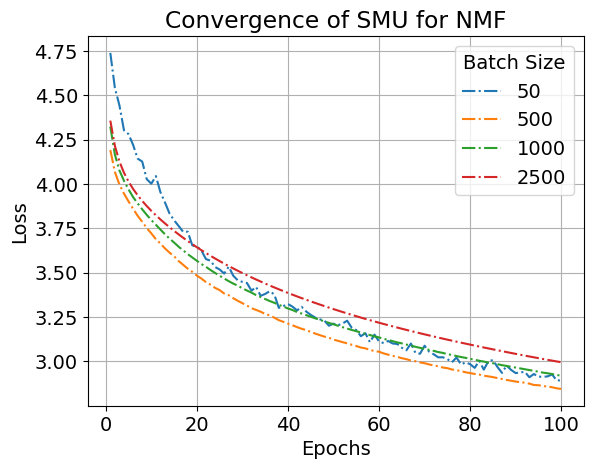

In [12]:
for i,b in enumerate(batch_size): 
    plt.plot(np.arange(1,101), loss_stds[i][1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title(f"Convergence of SMU for NMF")
plt.grid()
plt.savefig("fig/std_conv.png")
plt.show()

In [15]:
# Convergence of Adversarial NMF
plt.rcParams.update({'font.size': 14}) 
np.random.seed(0)

batch_size = [500,500,1000,2500]
batch_size_z = [100,250,500,5000]
linestyles = ['dashdot']*10
times = []
loss_advs = []

for i,b in enumerate(batch_size):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [64,64], epochs = 100, prob = "adv", true_sample = "std", normalize = True, update_H = False,
        mu_W = 1e-10, mu_H = 1e-10, batch_size = batch_size[i], batch_size_z = batch_size_z[i], tau_A = 0.1)
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_advs.append(nmf_sep.NMFs[0].fit_adv(U_r = U_sup[0], U_z = U_z[0], conv = True))

    tock = time.time()
    times.append(tock-tick)
print(times)


[8.030157804489136, 9.628808975219727, 7.924757957458496, 9.241659879684448]


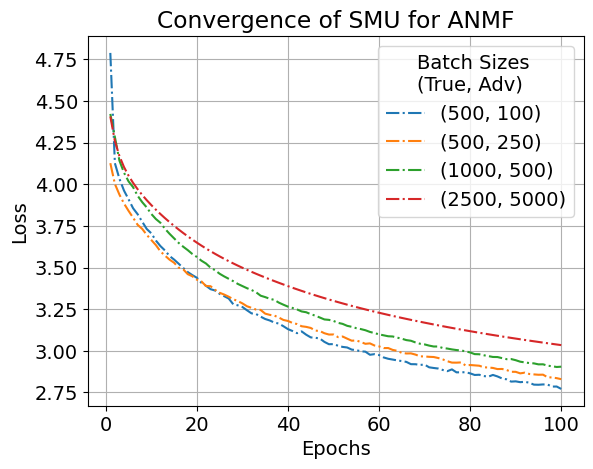

In [16]:
for i, b in enumerate(batch_size): 
    plt.plot(np.arange(1,len(loss_advs[i])), loss_advs[i][1:],label = f"({b}, {batch_size_z[i]})", linestyle = linestyles[i])
plt.legend(title = r"Batch Sizes " + "\n" + "(True, Adv)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for ANMF")
plt.grid()
plt.savefig("fig/adv_conv.png")
plt.show()


In [4]:
# Convergence of discriminative NMF
np.random.seed(1)
plt.rcParams.update({'font.size': 14}) 

batch_size_sup = [50,500,1000,2500]
linestyles = ['dashdot']*10
ds = [64,64]
times = []
loss_sups = []
for i,b in enumerate(batch_size_sup):
    tick = time.time()
    nmf = NMF(d = np.sum(ds), ds = ds, epochs = 100, mu_W = 1e-10, mu_H = 1e-10, warm_start_epochs = 10,batch_size_sup = b, normalize = True)
    loss_sups.append(nmf.fit_sup(U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[14.869096994400024, 6.6253907680511475, 6.081496000289917, 8.368319988250732]


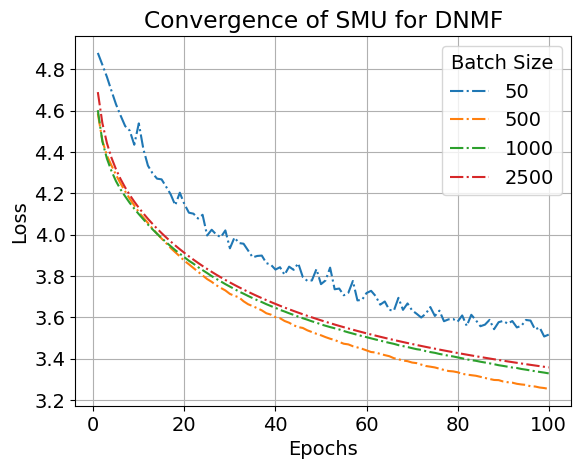

In [6]:
for i, b in enumerate(batch_size_sup):
    plt.plot(np.arange(1,101),loss_sups[i][0,1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for DNMF")
plt.grid()
plt.savefig("fig/sup_conv.png")
plt.show()

In [12]:
# Convergence of full NMF
plt.rcParams.update({'font.size': 14}) 

batch_size_r = [500,100,1000,2500]
batch_size_z = [100, 100, 250, 5000]
batch_size_sup = [100, 500, 1000, 2500]
linestyles = ['dashdot']*10
ds = [32,32]
times = []
loss_fulls = []
for i,b in enumerate(batch_size_r):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [64,64], epochs = 100, mu_W = 1e-10, mu_H = 1e-10, prob = "full",
        batch_size = batch_size_r[i], batch_size_z = batch_size_z[i], batch_size_sup = batch_size_sup[i], tau_A = 0.05, tau_S = 0.5,
        true_sample = "sup")
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_fulls.append(nmf_sep.NMF_concat.fit_full(U_r = U_sup, U_z = U_z, U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
    

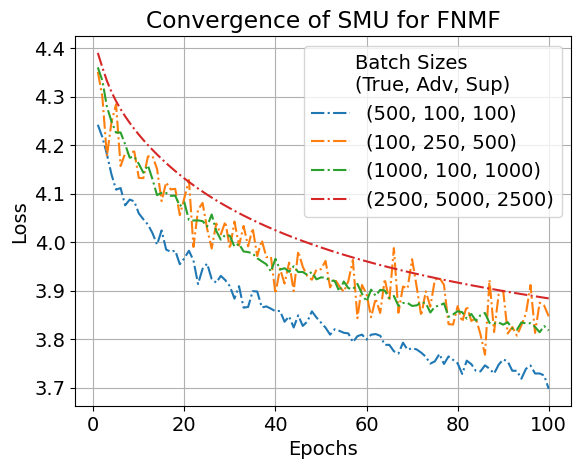

[46.89864492416382, 34.930989027023315, 31.53271794319153, 30.26111674308777]


In [13]:
for i, b in enumerate(batch_size_r):
    plt.plot(np.arange(1,101),loss_fulls[i][0,1:],label = f"({b}, {batch_size_z[i]}, {batch_size_sup[i]})", linestyle = linestyles[i])
plt.legend(title = "Batch Sizes" + '\n' + "(True, Adv, Sup)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for FNMF")
plt.grid()
plt.savefig("fig/full_conv.png")
plt.show()


print(times)

We see that for all methods converge, and smaller batch sizes tend to yield faster convergence. Selecting the batch sizes too small can lead to slower convergence and too much randomness. It is also interesting to see that standard NMF converges to a smaller loss than DNMF, because DNMF. This is to be expected as DNMF has to fit the basises while also splitting mixed data, while standard NMF only has to learn bases.


Data rich experiment
---

In this experiment we want to test the proposed methods in a setting where we have a lot of both weak and strong supervised data to see how the data settings compare. We test this on $0$ and $1$ digits, as NMF performs relatively well in this situation. We select $2500$ of each source, $2500$ mixed data and $2500$ strong supervised data. The mixed data is generated so that none of the mixed images are the same as the source images. In other words, no observed data from $\mathbb{P}_{U_i}$ is used to generate observed data from $\mathbb{P}_V$.


In [14]:
# Parameters for experiment
np.random.seed(1)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_adv = 1000
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-8
mu_H = 1e-6

epochs = 100
test_epochs = 100
batch_size = 500
batch_size_sup = 500
batch_size_z = 100
wiener = True

Ds = [16,32,48,64,80,96,112,128]

probs = ["std", "adv","sup","exem"]

df = pd.DataFrame(columns = ["id", "d", "prob", "mean_psnrs"])

taus = [0.0,0.1,0.0,0.0]


for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    # Each problem, each source, each data
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
  

    seps = []
    for j,d in enumerate(Ds):
        for i, prob in enumerate(probs):
            print(prob)

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs,prob = prob, use_adv_basis = False,
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_z = d, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])

            if prob == "std" or prob == "exem" or prob == "adv": 
                sep.fit(U_r = U_sup, V = V_sup)
            else:
                sep.fit(U_sup = U_sup, V_sup = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)


            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])
            seps.append(deepcopy(sep))

df.to_csv('data_rich.csv')

std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem


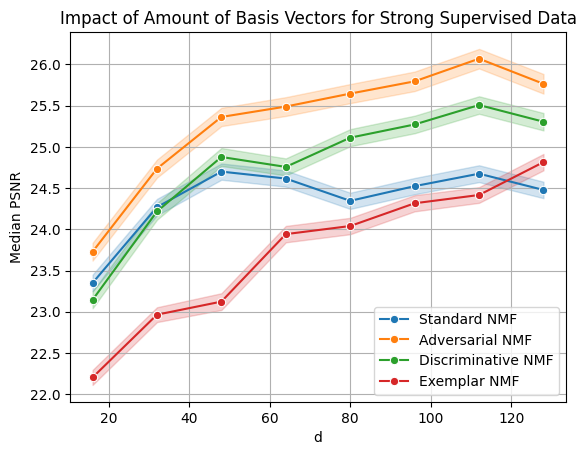

In [16]:
data_rich_df = pd.read_csv('data_rich.csv', index_col = 0)
plt.rcParams.update({'font.size': 10}) 
seaborn.lineplot(data_rich_df, x = "d", y = "mean_psnrs", hue = "prob", 
    estimator = "median", errorbar = "se", markers = True, dashes = True ,
    marker = 'o',legend=False)
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = ["Standard NMF", "_nolegend_" , "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_", "Exemplar NMF"])
plt.title("Impact of Amount of Basis Vectors for Strong Supervised Data")
plt.savefig("fig/Data_rich.pdf")
plt.show()

Data rich - Specific example
---

In [38]:
seps_ = seps[12:16]
for sep in seps_:
    sep.wiener = True
    print(sep.ds)

psnrs_std = seps_[0].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test, "psnr" , axis = 0)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test, "psnr", axis = 0)

out_std = seps_[0].separate(V_test[:,:])
out_adv = seps_[1].separate(V_test[:,:])
out_sup = seps_[2].separate(V_test[:,:])
out_exem = seps_[3].separate(V_test[:,:])

diff_adv = []

for i in range(len(psnrs_std)):
    diff_adv.append(psnrs_adv[i]-psnrs_std[i])

ids = np.argsort(diff_adv)

psnrs_std = seps_[0].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)


[64, 64]
[64, 64]
[64, 64]
[64, 64]


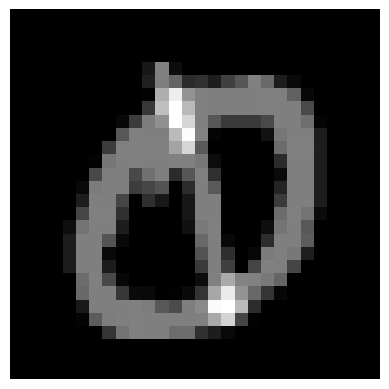

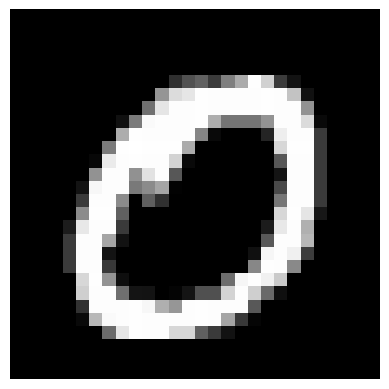

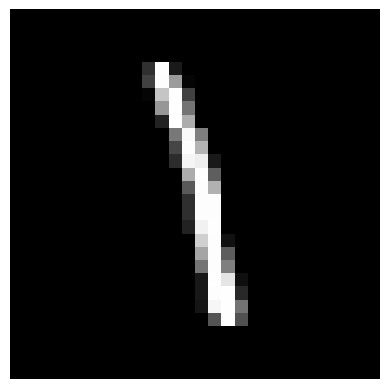

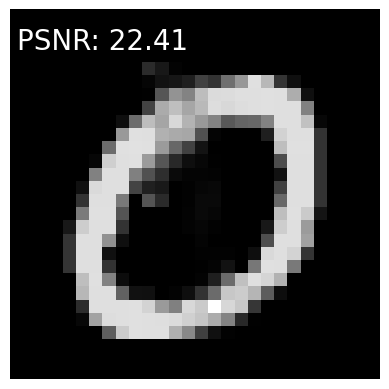

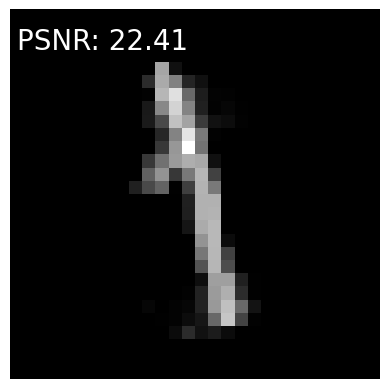

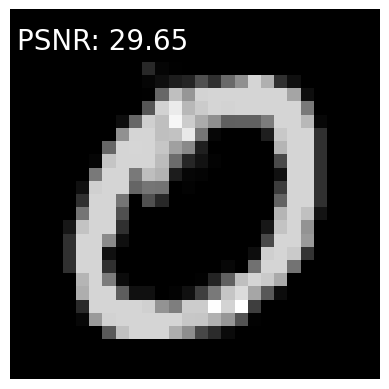

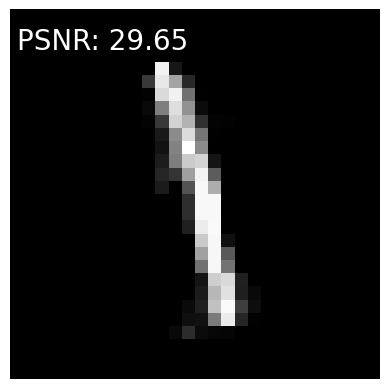

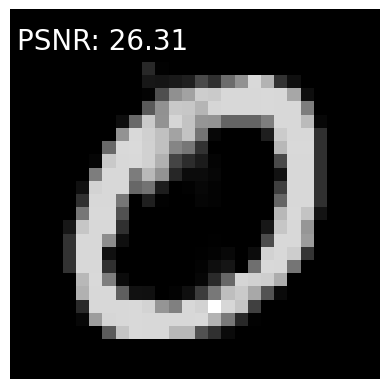

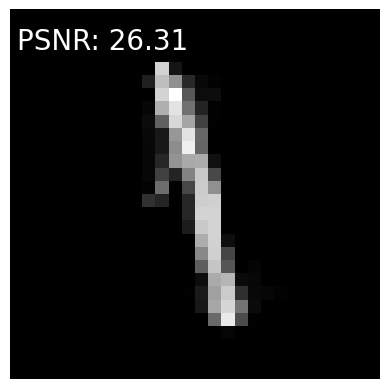

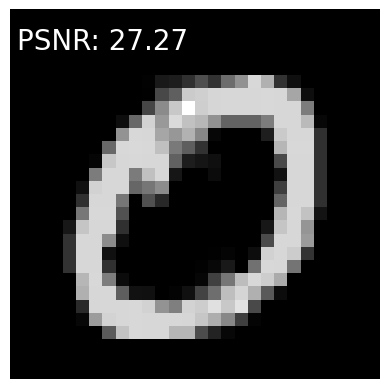

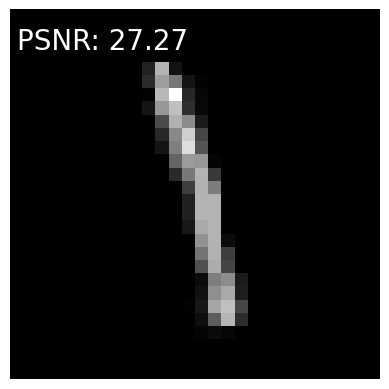

In [39]:
id = ids[-1] # 361
vmin = 0
vmax = 0.5



plt.imshow(V_test[:,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/v.png', bbox_inches = "tight")
plt.show()


plt.imshow(U_test[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u0.png', bbox_inches = "tight")
plt.show()


plt.imshow(U_test[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u1.png', bbox_inches = "tight")
plt.show()


fig, ax = plt.subplots()
ax.imshow(out_std[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_std_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_std[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_std_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_adv[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_adv_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_adv[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_adv_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_sup[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_sup_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_sup[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_sup_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_exem[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_exem_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_exem[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_exem_psnr.png', bbox_inches = "tight")
plt.show()




Data rich - Effect of $\tau_A$
---

In [13]:
np.random.seed(1)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_adv = 1000
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-8
mu_H = 1e-6

epochs_std = 100
epochs = 100
test_epochs = 100
batch_size = 500
batch_size_sup = 500
batch_size_z = 100
wiener = True

Ds = [32,64,96,128]

probs = ["std", "adv","adv","adv", "adv", "adv", "adv"]

df = pd.DataFrame(columns = ["id", "d", "prob", "tau", "mean_psnrs"])

taus = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]


for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()
    #mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    #U_r = []
    #for i in range(M):
    #    U_r.append(np.copy(mnist.x_r_train[i].reshape((mnist.Ns_adv[i],784)).T))
    #V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 

    seps = []
    for j,d in enumerate(Ds):
        for i, prob in enumerate(probs):
            print(prob)

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs_std if prob == "std" else epochs,prob = prob, use_adv_basis = False,
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_z = d, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])
            
            sep.fit(U_r = U_sup, V = V_sup, U_sup = U_sup, V_sup = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)


            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "tau": [taus[i]]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])
            seps.append(deepcopy(sep))

df.to_csv('data_rich_tau.csv')

std


In [1]:
data_rich_tau_df = pd.read_csv('data_rich_tau.csv', index_col = 0)
plt.rcParams.update({'font.size': 10}) 
seaborn.lineplot(data_rich_tau_df, x = "tau", y = "mean_psnrs", hue = "d",
    estimator = "median", errorbar = "se", markers = True, dashes = True,
    marker = 'o',legend=False, palette = "flare")
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = [r"$d = 32$", "_nolegend_" , r"$d = 64$", "_nolegend_", r"$d = 96$", "_nolegend", r"$d = 128$"])
plt.title("Impact of " + r"$\tau_A$" + " for ANMF")
plt.xlabel(r"$\tau_A$")
plt.savefig("fig/Data_rich_tau.pdf")
plt.show()

NameError: name 'pd' is not defined

Data poor tuning experiment
---



In [7]:
"""
BIG NUMERICAL EXAMPLE WITH RANDOM SEARCH
- Test for different M
- Test all models by first selecting optimal exemplar based -> Use W in std -> use W in adv, sup and full
- Record the difference in PSNR between the different methods and the std method
- Store results in dictionary/DataFrame
"""
np.random.seed(0)
number_of_experiments = 1
number_of_searches = 1
M = 2
Ms_all = [0,2,3,4,5,6,7,8,9]
N_adv = 400
N_V = 200
N_sup = 200
N_sup_test = 1000

d_dict = {"name": 'ds', "dist": lambda: [96, 96]}
d_exem_dict = {"name": 'ds', "dist": lambda: [400, 400]}
normalize_dict = {"name": 'normalize', "dist": lambda: np.random.choice([True,False], replace = True)}
mu_H_dict = {"name": 'mu_H', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(1,100)}
test_epochs_dict = {"name": 'test_epochs', "dist": lambda: np.random.randint(100,150)}
batch_size_r_dict = {"name": 'batch_size', "dist": lambda: np.random.choice([200,400], replace = True)}
batch_size_z_dict = {"name": 'batch_size_z', "dist": lambda: np.random.choice([100,200,400], replace = True)}
batch_size_sup_dict = {"name": 'batch_size_sup', "dist": lambda: np.random.choice([100], replace = True)}
true_sample_dict = {"name": 'true_sample', "dist": lambda: np.random.choice(["std", "sup"], replace = True)}
tau_A_dict = {"name": 'tau_A', "dist": lambda: np.random.uniform(0.0,0.3)}
tau_S_dict = {"name": 'tau_S', "dist": lambda: np.random.uniform(0.0,0.5)}
betas_dict = {"name": 'betas', "dist": lambda: [np.random.uniform(0.5,1.0), np.random.uniform(0.5,1.0)]} 

probs = ["exem", "std", "adv", "sup", "full"]
results = {"M": [], "exem" : [], "std" : [], "adv" : [], "sup" : [], "full": []}

for i in range(number_of_experiments):
    print(i)

    mnist = MNIST()

    Ms = [1,i + (i>=1)]

    mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    U_r = []
    for i in range(M):
        U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
    V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)
    
    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
    U_test_fit = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])
        U_test_fit.append(U_test[:,i,:])
    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)


    for prob in probs:
        print(prob)

        prob_dict = {"name": 'prob', "dist": lambda: prob}

        if prob == "exem" or prob == "std":
            W_dict = {"name": 'Ws', "dist": lambda: None}

        param_dicts_without_d = [ 
            normalize_dict,
            mu_H_dict, 
            prob_dict, 
            mu_W_dict, 
            epochs_dict, 
            test_epochs_dict,
            batch_size_r_dict, 
            batch_size_z_dict, 
            batch_size_sup_dict,
            tau_A_dict,
            tau_S_dict,
            true_sample_dict,
            betas_dict,
            W_dict,
        ]
        param_dicts = param_dicts_without_d + [d_dict] if prob != "exem" else param_dicts_without_d + [d_exem_dict]

        rs = random_search(NMF_separation, param_dicts, N_ex = number_of_searches, cv = 0 if prob != "full" and prob != "sup" else 2, source_aggregate = "mean", data_aggregate = "median")
        rs.fit(U_r = U_r, V = V, U_sup = U_sup, V_sup = V_sup)

        results[prob].append(np.median(rs.best_model.eval(U_test[:,:,:],V_test[:,:], "psnr")))
        results["M"].append(i + (i>=1))

        if prob == "std" or prob == "exem":
            Ws = [np.copy(rs.best_model.NMFs[0].W), np.copy(rs.best_model.NMFs[1].W)]
            W_dict = {"name": 'Ws', "dist": lambda : Ws}

0
exem
std
adv
sup
full
1
exem
std
adv
sup
full
2
exem
std
adv
sup
full
3
exem
std
adv
sup
full
4
exem
std
adv
sup
full
5
exem
std
adv
sup
full
6
exem
std
adv
sup
full
7
exem
std
adv
sup
full
8
exem
std
adv
sup
full


ValueError: All arrays must be of the same length

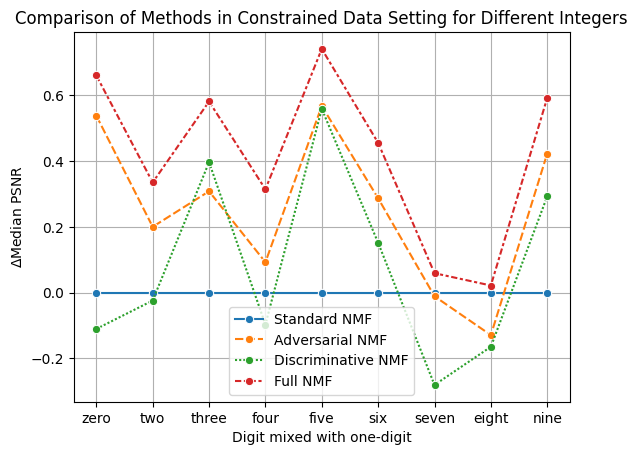

In [8]:
data_poor_df = pd.read_csv('data_poor_tuning.csv', index_col = 0)
for i in range(len(data_poor_df)):
    data_poor_df["M"].loc[i] = i + (i>=1)
new_df = data_poor_df.copy(deep = True)
#
for column in new_df:
    if column != "M":
        new_df[column] = new_df[column] - data_poor_df["std"]
ax = seaborn.lineplot(data = new_df.drop("M", axis = 1).drop("exem", axis = 1), marker = 'o')
ax.set_xticklabels(['','zero', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
ax.set_xlabel("Digit mixed with one-digit")
ax.set_ylabel(r"$\Delta$" + "Median PSNR")
plt.title("Comparison of Methods in Constrained Data Setting for Different Integers")
plt.legend(labels = ["Standard NMF", "_nolegend_", "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_", "Full NMF"], loc = "lower center")
plt.grid()
plt.savefig('fig/data_poor.pdf')
plt.show()
